In [ ]:
# !pip install -qq PyPDF2
import PyPDF2
import re
from nltk.corpus import words
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import glob
import numpy as np
import nltk
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
nltk.download("words")

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/ee_skripsie.carla.2022-08-08.zip 

In [ ]:
#read in training data
import os
import pandas as pd

fileNames = []
numPages = []
dirs = ["/content/2017/","/content/2018/","/content/2019/","/content/2020/"]

for ss in dirs:

  for filename in os.listdir(ss):
     
          dir = ss+ filename
          pdffileobj=open(dir,'rb')
          pdfreader=PyPDF2.PdfFileReader(pdffileobj)
          pageNums = pdfreader.numPages
          fileNames.append(filename[:-4])
          numPages.append(pageNums)
          
    

In [ ]:
zipped = list(zip(fileNames, numPages))
featDF = pd.DataFrame(zipped, columns=['Name', 'numPages'])

NameError: ignored

In [ ]:
marks = pd.read_csv('/content/docs/ml4ed_marks.2022-08-08.csv')
# marks = pd.read_csv('/root/docs/ml4ed_marks.2022-08-08.csv')

In [ ]:
def getMark(markDF,reportID):
  index = markDF.loc[markDF['report_id'] == reportID]
  index = index.mark
  return index.item()

In [ ]:
#append Student Marks
sortedMarks = []
for row in featDF.iterrows():
  pdfName = row[1].Name
  pdfName = int(pdfName)
  m = getMark(marks,pdfName)
  sortedMarks.append(m)


In [ ]:
featDF['Mark'] = sortedMarks

In [ ]:
#read in validation data
valFileNames = pd.read_csv('/content/docs/split_val.2022-08-08.txt',header = None)
valFileNames.columns = ["fileName"]
valFileNames = valFileNames.fileName.tolist()
valMarks = []
valFiles = []
valPageNums = []
for filename in os.listdir('/content/2021/'):
  if int(filename[:-4]) in valFileNames:
    dir = ""
    m = getMark(marks,int(filename[:-4]))
    valFiles.append(filename[:-4])
    valMarks.append(m)
    dir = '/content/2021/' + filename
    pdffileobj=open(dir,'rb')
    pdfreader=PyPDF2.PdfFileReader(pdffileobj)
    valPageNums.append(pdfreader.numPages)

  

 

FileNotFoundError: ignored

In [ ]:
zipped = list(zip(valFiles, valMarks,valPageNums))
val_feat_df = pd.DataFrame(zipped, columns=['Name', 'Mark',"numPages"])

In [ ]:
#read in test data
valFileNames = pd.read_csv('/content/docs/split_val.2022-08-08.txt',header = None)
valFileNames.columns = ["fileName"]
valFileNames = valFileNames.fileName.tolist()
valMarks = []
valFiles = []
valPageNums = []
for filename in os.listdir('/content/2021/'):
  if int(filename[:-4]) not in valFileNames:
    dir = ""
    m = getMark(marks,int(filename[:-4]))
    valFiles.append(filename[:-4])
    valMarks.append(m)
    dir = '/content/2021/' + filename
    pdffileobj=open(dir,'rb')
    pdfreader=PyPDF2.PdfFileReader(pdffileobj)
    valPageNums.append(pdfreader.numPages)

In [ ]:
zipped = list(zip(valFiles, valMarks,valPageNums))
test_feat_df = pd.DataFrame(zipped, columns=['Name', 'Mark',"numPages"])

Extract Additional Features

In [ ]:
def getPageNums_and_Mark(DF, reportID):
  index = DF.loc[DF['Name'] == reportID]
  m = index.Mark
  p = index.numPages
  return m.item(), p.item()


In [ ]:
import math


In [ ]:
# herman text
!unzip -qq /content/HERMAN_TEXT.zip

In [ ]:
!unzip -qq /content/20170005_00001.zip
!unzip -qq /content/20180028_00001.zip
!unzip -qq /content/20190015_00001.zip
!unzip -qq /content/20200006_00001.zip
!unzip -qq /content/20210019_00001.zip

unzip:  cannot find or open /content/20170005_00001.zip, /content/20170005_00001.zip.zip or /content/20170005_00001.zip.ZIP.
unzip:  cannot find or open /content/20180028_00001.zip, /content/20180028_00001.zip.zip or /content/20180028_00001.zip.ZIP.
unzip:  cannot find or open /content/20190015_00001.zip, /content/20190015_00001.zip.zip or /content/20190015_00001.zip.ZIP.
unzip:  cannot find or open /content/20200006_00001.zip, /content/20200006_00001.zip.zip or /content/20200006_00001.zip.ZIP.
unzip:  cannot find or open /content/20210019_00001.zip, /content/20210019_00001.zip.zip or /content/20210019_00001.zip.ZIP.


In [ ]:
# Create English word list

# NLTK
en_words = set(words.words())

# aspell
fn = Path("/content")/"en_super.dict"
print("Reading:", fn)
with open(fn, "r") as f:
    for line in f:
        en_words.add(line.strip())

print("No. words:", len(en_words))

Reading: /content/en_super.dict
No. words: 322293


In [ ]:
def get_txt_feats(txt_fn):
    with open(txt_fn) as f:
        lines = f.readlines()
        # text = 

    n_words = 0
    spell_mistakes = []
    for word in wordpunct_tokenize("".join(lines)):
        if not word.isalpha():
            continue
        n_words += 1
        if not (word.lower() in en_words):
            spell_mistakes.append(word)

    n_figures = 0
    n_tables = 0
    n_equations = 0
    n_references = 0
    n_lines_start_at = 0
    for line in lines:
        # if re.match("^figure.*", line.lower()):
        if re.match(r"^figure.*[^\d]$", line.strip().lower()):
            # print("Fig:", line)
            n_figures += 1
        # elif re.match("^table.*", line.strip().lower()):
        elif re.match("^table.*[^\d]$", line.strip().lower()):
            # print("Tab:", line)
            n_tables += 1
        elif re.match("^\([\d\.]*\)$", line.strip().lower()):
            # print("Eq:", line)
            n_equations += 1
        elif re.match(r"^\[\d*\]", line.lower()):
            n_references += 1
        elif re.match(r"^\@.*", line.lower()):
            n_lines_start_at += 1

    return {
        "n_words": n_words,
        "spell_mistakes": spell_mistakes,
        "n_figures": n_figures,
        "n_tables": n_tables,
        "n_equations": n_equations,
        "n_references": n_references,
        "n_lines_start_at": n_lines_start_at
        }

In [ ]:
# extract training data features
n_words_List = []
spell_mistakes_List = []
spell_mistake_types_list = []
figure_list = []
tables_list = []
equation_list = []
n_ref_list = []
n_lines_start_list = []
projectNames = []
projectMarks = []
pageCounts = []

for filename in os.listdir('/content/HERMAN_TEXT'):
  if filename[0] != "s":
    if filename.endswith('txt') and int(filename[:4]) != 2021:
      
      name = '/content/HERMAN_TEXT/'+ filename
      # n_words, spell_mistakes, n_figures, n_tables, n_equations, n_references, n_lines_start_at = get_txt_feats(filename)
      features = get_txt_feats(name)
      n_words_List.append(features['n_words'])
      spell_mistakes_List.append(len(features["spell_mistakes"]))
      spell_mistake_types_list.append(len(set(features["spell_mistakes"])))
      figure_list.append(features["n_figures"])
      tables_list.append(features["n_tables"])
      equation_list.append(features["n_equations"])
      n_ref_list.append(features["n_references"])
      n_lines_start_list.append(features["n_lines_start_at"])
      projectNames.append(filename[:8])
      p_mark, p_count = getPageNums_and_Mark(featDF, filename[:8])
      projectMarks.append(p_mark)
      pageCounts.append(p_count)
    

In [ ]:
zipped = list(zip(projectNames,n_words_List, pageCounts, spell_mistakes_List,spell_mistake_types_list,figure_list,tables_list,equation_list,n_ref_list, n_lines_start_list,projectMarks))
feature_train_df = pd.DataFrame(zipped, columns=['reportID', 'numWords',"numPages","n_spell_mistakes",'n_spell_mistakes_types',"n_figures","n_tables","n_equations","n_references","n_lines_start","mark"])


In [ ]:
# extract features from validation data

n_words_List = []
spell_mistakes_List = []
spell_mistake_types_list = []
figure_list = []
tables_list = []
equation_list = []
n_ref_list = []
n_lines_start_list = []
projectNames = []
projectMarks = []
pageCounts = []

for filename in os.listdir('/content/HERMAN_TEXT'):
  if filename[0] != "s":
    if filename.endswith('txt') and int(filename[:4]) == 2021 and int(filename[5:8])<=59:

      name = '/content/HERMAN_TEXT/'+ filename
      # n_words, spell_mistakes, n_figures, n_tables, n_equations, n_references, n_lines_start_at = get_txt_feats(filename)
      features = get_txt_feats(name)
      n_words_List.append(features['n_words'])
      spell_mistakes_List.append(len(features["spell_mistakes"]))
      spell_mistake_types_list.append(len(set(features["spell_mistakes"])))
      figure_list.append(features["n_figures"])
      tables_list.append(features["n_tables"])
      equation_list.append(features["n_equations"])
      n_ref_list.append(features["n_references"])
      n_lines_start_list.append(features["n_lines_start_at"])
      projectNames.append(filename[:8])
      p_mark, p_count = getPageNums_and_Mark(val_feat_df, filename[:8])
      projectMarks.append(p_mark)
      pageCounts.append(p_count)



In [ ]:
zipped = list(zip(projectNames,n_words_List, pageCounts, spell_mistakes_List,spell_mistake_types_list,figure_list,tables_list,equation_list,n_ref_list, n_lines_start_list,projectMarks))
feature_val_df = pd.DataFrame(zipped, columns=['reportID', 'numWords',"numPages","n_spell_mistakes",'n_spell_mistakes_types',"n_figures","n_tables","n_equations","n_references","n_lines_start","mark"])


In [ ]:
# extract features from training data

n_words_List = []
spell_mistakes_List = []
spell_mistake_types_list = []
figure_list = []
tables_list = []
equation_list = []
n_ref_list = []
n_lines_start_list = []
projectNames = []
projectMarks = []
pageCounts = []

for filename in os.listdir('/content/HERMAN_TEXT'):
  if filename[0] != "s":
    if filename.endswith('txt') and int(filename[:4]) == 2021 and int(filename[5:8])>59:

      name = '/content/HERMAN_TEXT/'+ filename
      # n_words, spell_mistakes, n_figures, n_tables, n_equations, n_references, n_lines_start_at = get_txt_feats(filename)
      features = get_txt_feats(name)
      n_words_List.append(features['n_words'])
      spell_mistakes_List.append(len(features["spell_mistakes"]))
      spell_mistake_types_list.append(len(set(features["spell_mistakes"])))
      figure_list.append(features["n_figures"])
      tables_list.append(features["n_tables"])
      equation_list.append(features["n_equations"])
      n_ref_list.append(features["n_references"])
      n_lines_start_list.append(features["n_lines_start_at"])
      projectNames.append(filename[:8])
      p_mark, p_count = getPageNums_and_Mark(test_feat_df, filename[:8])
      projectMarks.append(p_mark)
      pageCounts.append(p_count)

In [ ]:
zipped = list(zip(projectNames,n_words_List, pageCounts, spell_mistakes_List,spell_mistake_types_list,figure_list,tables_list,equation_list,n_ref_list, n_lines_start_list,projectMarks))
feature_test_df = pd.DataFrame(zipped, columns=['reportID', 'numWords',"numPages","n_spell_mistakes",'n_spell_mistakes_types',"n_figures","n_tables","n_equations","n_references","n_lines_start","mark"])


Normalized DataFrame

In [ ]:
def normalize(df,trainDF):
    result = df.copy()
    for feature_name in df.columns:
      if feature_name != "reportID" and feature_name != "mark":
        mean_value = trainDF[feature_name].mean()
        std_value = trainDF[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) / std_value

      # if feature_name == "mark":
      #   result[feature_name] = (df[feature_name]/100)
    return result

normalized_train_DF = normalize(feature_train_df,feature_train_df)
normalized_val_DF = normalize(feature_val_df,feature_train_df)
normalized_test_DF = normalize(feature_test_df,feature_train_df)


feature_train_df = normalized_train_DF
feature_val_df = normalized_val_DF


Linear regression with page count


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
y = feature_train_df['mark'].values.reshape(-1, 1)
X = feature_train_df['numPages'].values.reshape(-1, 1)
y_test = feature_val_df['mark'].values.reshape(-1, 1)
X_test = feature_val_df['numPages'].values.reshape(-1, 1)

In [ ]:
regressor1 = LinearRegression()
regressor1.fit(X, y)
y_pred = regressor1.predict(X_test)
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
rms = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rms)

rmse: 12.581180868106884


In [ ]:
MSE = np.square(np.subtract(y_test,y_pred)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

12.581180868106884


In [ ]:
y_pred = np.ones(len(feature_val_df))*feature_train_df['mark'].values.mean()
rms = mean_squared_error(y_test, y_pred, squared=False)
rms

13.175861977756202

Linear regression with word count

In [ ]:
y = feature_train_df['mark'].values.reshape(-1, 1)
X = feature_train_df['numWords'].values.reshape(-1, 1)
y_test = feature_val_df['mark'].values.reshape(-1, 1)
X_test = feature_val_df['numWords'].values.reshape(-1, 1)

In [ ]:
regressor2 = LinearRegression()
regressor2.fit(X, y)
y_pred = regressor2.predict(X_test)
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
rms = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rms)

rmse: 11.49774484273451


NN with page count

In [ ]:
feature_train_df = pd.read_csv("/content/all_features_train.csv")
feature_val_df = pd.read_csv("/content/all_features_val.csv")

In [ ]:
from tensorflow import keras
import numpy as np
from keras.models import Sequential
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
y = feature_train_df['mark'].values.reshape(-1, 1)
X = feature_train_df['numPages'].values.reshape(-1, 1)
y_test = feature_val_df['mark'].values.reshape(-1, 1)
X_test = feature_val_df['numPages'].values.reshape(-1, 1)

In [ ]:
model1 = Sequential()
model1.add(Dense(10, input_dim=1, kernel_initializer='normal', activation='relu'))
model1.add(Dense(10, kernel_initializer='normal', activation='relu'))
model1.add(Dense(32, kernel_initializer='normal', activation='tanh'))

model1.add(Dense(1))

# model1.add(Dense(1, input_dim=1, kernel_initializer='normal', activation='relu'))
# model1.add(Dense(32, kernel_initializer='normal', activation='relu'))
# model1.add(Dense(16, kernel_initializer='normal', activation='relu'))

# model1.add(Dense(1))

In [ ]:
loss_fn = keras.losses.MeanSquaredError()
num_epochs = 500
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=loss_fn
)


In [ ]:
r = model1.fit(X,y,epochs = num_epochs,verbose = 0,validation_data = [X_test,y_test])

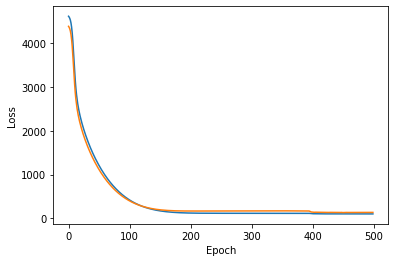

In [ ]:
#plot training loss
plt.plot(range(num_epochs),r.history["loss"])
plt.plot(range(num_epochs),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model1.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:",rms)

2/2 [==============================] - 0s 4ms/step
rmse: 11.7530010425469


NN with word count

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
y = feature_train_df['mark'].values.reshape(-1, 1)
X = feature_train_df['numWords'].values.reshape(-1, 1)
y_test = feature_val_df['mark'].values.reshape(-1, 1)
X_test = feature_val_df['numWords'].values.reshape(-1, 1)

In [ ]:
# model2 = Sequential()
# model2.add(Dense(32, input_dim=1, kernel_initializer='normal', activation='relu'))
# model2.add(Dropout(0.2))

# model2.add(Dense(16, input_dim=1, kernel_initializer='normal', activation='relu'))


# model2.add(Dense(1))


model2 = Sequential()
model2.add(Dense(1, input_dim=1, kernel_initializer='he_normal', activation='relu'))
model2.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, input_dim=1, kernel_initializer='he_normal', activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))

In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError()
)

In [ ]:
# num_epochs = 400

num_epochs = 500

In [ ]:
r2 = model2.fit(X,y,epochs = num_epochs,batch_size = 32,verbose = 0,validation_data = [X_test, y_test])

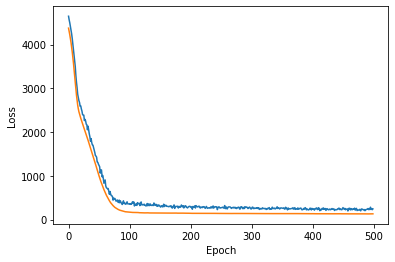

In [ ]:
#plot training loss
plt.plot(range(num_epochs),r2.history["loss"])
plt.plot(range(num_epochs),r2.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model2.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:",rms)

rmse: 11.49679054573805


Plot num Pages model curve

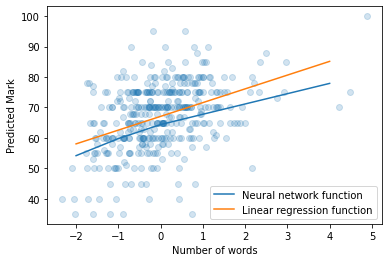

In [ ]:
minPage = feature_train_df['numWords'].values.min()
maxPage = feature_train_df['numWords'].values.max()
X_try = np.linspace(int(minPage), int(maxPage),(int(maxPage)-int(minPage))+1)

y_try = model2.predict(X_try)
X_try = X_try.reshape(-1,1)
y_try_regress = regressor2.predict(X_try)
plt.plot(X_try,y_try,label = "Neural network function")
plt.plot(X_try,y_try_regress, label = "Linear regression function")
plt.legend()
plt.xlabel("Number of words")
plt.ylabel("Predicted Mark")
plt.scatter(feature_train_df['numWords'].values,feature_train_df['mark'].values,alpha = 0.2)
plt.show()

LR with all features

In [ ]:
X = normalized_train_DF[['numWords',"numPages","n_spell_mistakes",'n_spell_mistakes_types',"n_figures","n_tables","n_equations","n_references","n_lines_start"]].values
y =  normalized_train_DF['mark'].values

X_val = normalized_val_DF[['numWords',"numPages","n_spell_mistakes",'n_spell_mistakes_types',"n_figures","n_tables","n_equations","n_references","n_lines_start"]].values
y_val =  normalized_val_DF['mark'].values


regressor = LinearRegression()
regressor.fit(X, y)
y_pred = regressor.predict(X_val)
df_preds = pd.DataFrame({'Actual': y_val.squeeze(), 'Predicted': y_pred.squeeze()})
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:", rms)

rmse: 11.739639007392807


NN with all features

In [ ]:
X = normalized_train_DF[['numWords',"numPages","n_spell_mistakes",'n_spell_mistakes_types',"n_figures","n_tables","n_equations","n_references","n_lines_start"]].values
y =  normalized_train_DF['mark'].values

X_val = normalized_val_DF[['numWords',"numPages","n_spell_mistakes",'n_spell_mistakes_types',"n_figures","n_tables","n_equations","n_references","n_lines_start"]].values
y_val =  normalized_val_DF['mark'].values

# X_test = np.asarray(X_test,dtype = 'float')
# y_test = np.asarray(y_test,dtype = 'float')

In [ ]:
regressor2 = LinearRegression()
regressor2.fit(X, y)
y_pred = regressor2.predict(X_val)
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:", rms)

rmse: 11.739639007392807


In [ ]:
model = Sequential()
 
model.add(Dense(units=9, input_dim=9, kernel_initializer='he_normal', activation='linear'))
model.add(Dense(units=9, kernel_initializer='he_normal', activation='linear'))
# model.add(Dropout(0.1))
# model.add(Dense(units=9, kernel_initializer='he_normal', activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(units=9, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(units=3, kernel_initializer='he_normal', activation='linear'))
model.add(Dense(1,activation='linear'))




In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
loss_fn = keras.losses.MeanSquaredError()
num_epochs = 550
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_fn)

In [ ]:
r = model.fit(X,y,epochs = num_epochs,verbose = 0,batch_size = 16,validation_data = (X_val, y_val),callbacks=[es])

Epoch 238: early stopping


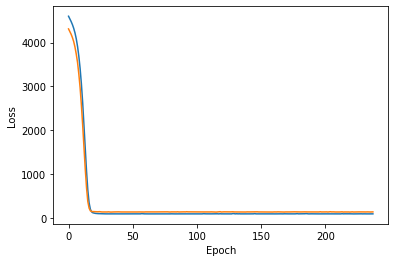

In [ ]:
plt.plot(range(len(r.history["loss"])),r.history["loss"])
plt.plot(range(len(r.history["loss"])),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
math.sqrt(model.evaluate(X_val,y_val))

2/2 [==============================] - 0s 8ms/step - loss: 138.4756


11.767564996102635

In [ ]:
y_pred = model.predict(X_val)
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:",rms)

rmse: 11.767564609496993


Plot num Pages model curve

In [ ]:
minPage = feature_train_df['numPages'].values.min()
maxPage = feature_train_df['numPages'].values.max()
X_try = np.linspace(int(minPage), int(maxPage),(int(maxPage)-int(minPage))+1)

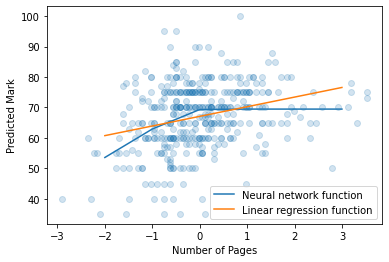

In [ ]:
y_try = model1.predict(X_try)
X_try = X_try.reshape(-1,1)
y_try_regress = regressor1.predict(X_try)
plt.plot(X_try,y_try,label = "Neural network function")
plt.plot(X_try,y_try_regress, label = "Linear regression function")
plt.legend()
plt.xlabel("Number of Pages")
plt.ylabel("Predicted Mark")
plt.scatter(feature_train_df['numPages'].values,feature_train_df['mark'].values,alpha = 0.2)
plt.show()

LongFormer NN

In [ ]:
import pickle
import torch
import io
from os.path import exists
import pandas as pd

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

#contents = pickle.load(f) becomes...
# contents = CPU_Unpickler(f).load()

filename = 'textDict.pickle'
if (exists(filename)):
    print('Loading existing Q values')
    # Load data (deserialize)
    with open(filename, 'rb') as handle:
        Q = CPU_Unpickler(handle).load()
        handle.close()

filename = 'valDict.pickle'

if (exists(filename)):
    print('Loading existing Q values')
    # Load data (deserialize)
    with open(filename, 'rb') as handle:
        valQ = CPU_Unpickler(handle).load()
        handle.close()

Q_marks_train = pd.read_csv('/content/Q_mark.csv')
Q_mark_val = pd.read_csv('/content/Q_mark_val.csv')

In [ ]:
from keras_preprocessing.sequence import pad_sequences

def padSequences(Q):
  paddedDict = {}
  padList = []
  for key, value in Q.items():
    padList = []
    for i in range(len(value)):
      arr = value[i].cpu()
      padded = pad_sequences(arr, maxlen=128,padding = "post")
      padList.append(padded)
    if len(padList) == 12:
      padList.append(np.zeros((1,128)))
    paddedDict[key] = padList

  return paddedDict

In [ ]:
def createLSTMdata(paddedDict):
  LSTMdata = np.zeros((len(paddedDict),128))
  j = 0
  for key, value in paddedDict.items():

    
      
        LSTMdata[j,:] = value[1]

        j += 1
  return LSTMdata

In [ ]:
trainData = createLSTMdata(padSequences(Q))
valData = createLSTMdata(padSequences(valQ))
y = Q_marks_train["Mark"].values
y_val =Q_mark_val["Mark"].values

NameError: ignored

In [ ]:
model = Sequential()
model.add(Dense(units=64, input_shape = (128,),kernel_initializer='glorot_normal', activation='elu'))
# model.add(Dropout(0.2))
# model.add(Dense(units=32, kernel_initializer='glorot_normal', activation='elu'))
# model.add(Dropout(0.1))
model.add(Dense(units=100, kernel_initializer='glorot_normal', activation='sigmoid'))
model.add(Dense(1))

In [ ]:
loss_fn = keras.losses.MeanSquaredError()
num_epochs = 80
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0008),
    loss=loss_fn
)

In [ ]:
r = model.fit(trainData,y,epochs = num_epochs, batch_size =16,verbose = 1,validation_data = [valData,y_val])

Epoch 1/80
26/26 [==============================] - 1s 8ms/step - loss: 4477.7402 - val_loss: 4181.5933
Epoch 2/80
26/26 [==============================] - 0s 3ms/step - loss: 4308.2891 - val_loss: 4017.9387
Epoch 3/80
26/26 [==============================] - 0s 3ms/step - loss: 4143.6055 - val_loss: 3863.3069
Epoch 4/80
26/26 [==============================] - 0s 3ms/step - loss: 3983.2800 - val_loss: 3705.1724
Epoch 5/80
26/26 [==============================] - 0s 3ms/step - loss: 3810.8787 - val_loss: 3521.2971
Epoch 6/80
26/26 [==============================] - 0s 3ms/step - loss: 3630.1204 - val_loss: 3356.4529
Epoch 7/80
26/26 [==============================] - 0s 3ms/step - loss: 3456.3188 - val_loss: 3166.2935
Epoch 8/80
26/26 [==============================] - 0s 3ms/step - loss: 3269.9084 - val_loss: 2992.0930
Epoch 9/80
26/26 [==============================] - 0s 3ms/step - loss: 3102.3772 - val_loss: 2832.1870
Epoch 10/80
26/26 [==============================] - 0s 3ms/step

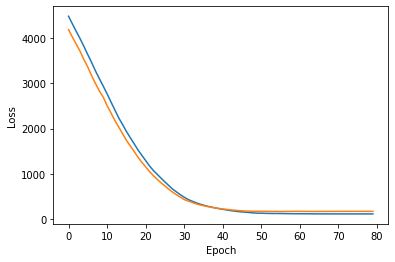

In [ ]:
plt.plot(range(num_epochs),r.history["loss"])
plt.plot(range(num_epochs),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model.predict(valData)
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:", rms)

2/2 [==============================] - 0s 4ms/step
rmse: 13.278018356406216


Topic Extraction

In [ ]:
# get summaries

!pip install -qq git+https://github.com/allenai/longformer.git

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 367, in resolve
    failure_causes = self._attempt_

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# abstract text

!unzip -qq /content/EEabstracts.zip



In [ ]:
swords = stopwords.words('english')
swords.append("the")
swords.append("we")
swords.append("this")
swords.append("project")
swords.append("report")
swords.append("using")



In [ ]:
import os
AbstractText = []
id_names = []
years = []

for filename in os.listdir("/content/EEabstracts/"):

  file = '/content/EEabstracts/' + filename
  if filename[:4] != "2021":
    with open(file) as f:
          lines = f.read()
    f.close()
    
    lines= lines.lower()
    text_tokens = word_tokenize(lines)
    tokens_without_sw = [word for word in text_tokens if not word in swords]
    text = (" ").join(tokens_without_sw)
    years.append(filename[:4])
    AbstractText.append(text)
    id_names.append(filename[:8])

In [ ]:
# zipped = list(zip(id_names,summaryText))
# summaryDF = pd.DataFrame(zipped, columns=['reportID', "sumText"])

zipped = list(zip(id_names,AbstractText, years))
summaryDF = pd.DataFrame(zipped, columns=['reportID', "sumText","year"])

In [ ]:

AbstractText = []
id_names = []

for filename in os.listdir("/content/EEabstracts/"):

  file = '/content/EEabstracts/' + filename
  if int(filename[:8]) <= 20210059 and filename[:4] == "2021":
    with open(file) as f:
          lines = f.read()
    f.close()
    lines = lines.lower()
    text_tokens = word_tokenize(lines)
    tokens_without_sw = [word for word in text_tokens if not word in swords]
    text = (" ").join(tokens_without_sw)

    AbstractText.append(text)
    id_names.append(filename[:8])


In [ ]:
zipped = list(zip(id_names,AbstractText))
summaryDFVAL = pd.DataFrame(zipped, columns=['reportID', "sumText"])

In [ ]:

AbstractText = []
id_names = []

for filename in os.listdir("/content/EEabstracts/"):

  file = '/content/EEabstracts/' + filename
  if int(filename[:8]) > 20210059 and filename[:4] == "2021":
    with open(file) as f:
          lines = f.read()
    f.close()
    lines = lines.lower()
    text_tokens = word_tokenize(lines)
    tokens_without_sw = [word for word in text_tokens if not word in swords]
    text = (" ").join(tokens_without_sw)

    AbstractText.append(text)
    id_names.append(filename[:8])

In [ ]:
zipped = list(zip(id_names,AbstractText))
summaryDFTEST = pd.DataFrame(zipped, columns=['reportID', "sumText"])

In [ ]:
!pip install -qq bertopic

     |████████████████████████████████| 90 kB 5.8 MB/s 
     |████████████████████████████████| 88 kB 6.6 MB/s 
     |████████████████████████████████| 636 kB 31.9 MB/s 
     |████████████████████████████████| 5.2 MB 46.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 5.3 MB 61.8 MB/s 
     |████████████████████████████████| 1.3 MB 68.5 MB/s 
     |████████████████████████████████| 163 kB 65.1 MB/s 
     |████████████████████████████████| 7.6 MB 60.0 MB/s 
     |████████████████████████████████| 1.1 MB 66.9 MB/s 


In [ ]:
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -qq bertopic[visualization]
!pip install distributed==1.25.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bertopic import BERTopic
# import bertopic

In [ ]:
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters = 8)
model = BERTopic(verbose=True,nr_topics = 8,language = "English",hdbscan_model = cluster_model)
 
#convert to list 
docs = summaryDF.sumText.to_list()
dates = summaryDF.year.to_list()
 
topics, probabilities = model.fit_transform(docs)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2022-10-27 21:19:36,179 - BERTopic - Transformed documents to Embeddings
2022-10-27 21:19:39,361 - BERTopic - Reduced dimensionality
2022-10-27 21:19:39,425 - BERTopic - Clustered reduced embeddings
2022-10-27 21:19:39,642 - BERTopic - Reduced number of topics from 8 to 8


In [ ]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 199 kB/s 


In [ ]:
import kaleido

topics_over_time = model.topics_over_time(docs, dates)
c = model.visualize_topics_over_time(topics_over_time)
# c.update_layout(title = "")
c.update_xaxes(nticks = 4)
c.write_image("/content/topicsOverTime.pdf")
c.show()

4it [00:00, 29.02it/s]


In [ ]:
topic_labels = model.generate_topic_labels(nr_words=3, topic_prefix=True, word_length=None, separator='_')

In [ ]:
topic_labels

['0_energy_solar_system',
 '1_system_problem_control',
 '2_time_acoustic_arrival',
 '3_system_data_design',
 '4_power_generator_design',
 '5_antenna_method_frequency',
 '6_system_sensor_data',
 '7_models_model_learning']

In [ ]:
d = model.visualize_barchart(n_words = 5)
d.write_image("/content/TopicWordScores.pdf")
d

In [ ]:
#get val data topics
valTopics = []

for i in summaryDFVAL.sumText:
  new_doc = i
  t = model.transform([new_doc])
  valTopics.append(t[0][0])

#get test data topics
testTopics = []

for i in summaryDFTEST.sumText:
  new_doc = i
  t = model.transform([new_doc])
  testTopics.append(t[0][0])



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:47:51,594 - BERTopic - Reduced dimensionality
2022-10-27 13:47:51,701 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:47:53,987 - BERTopic - Reduced dimensionality
2022-10-27 13:47:53,992 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:47:56,211 - BERTopic - Reduced dimensionality
2022-10-27 13:47:56,219 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:47:58,820 - BERTopic - Reduced dimensionality
2022-10-27 13:47:58,823 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:01,002 - BERTopic - Reduced dimensionality
2022-10-27 13:48:01,005 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:03,249 - BERTopic - Reduced dimensionality
2022-10-27 13:48:03,256 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:05,870 - BERTopic - Reduced dimensionality
2022-10-27 13:48:05,874 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:08,093 - BERTopic - Reduced dimensionality
2022-10-27 13:48:08,099 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:10,336 - BERTopic - Reduced dimensionality
2022-10-27 13:48:10,339 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:12,569 - BERTopic - Reduced dimensionality
2022-10-27 13:48:12,576 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:15,154 - BERTopic - Reduced dimensionality
2022-10-27 13:48:15,161 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:17,357 - BERTopic - Reduced dimensionality
2022-10-27 13:48:17,396 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:20,300 - BERTopic - Reduced dimensionality
2022-10-27 13:48:20,306 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:23,012 - BERTopic - Reduced dimensionality
2022-10-27 13:48:23,015 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:25,222 - BERTopic - Reduced dimensionality
2022-10-27 13:48:25,229 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:27,532 - BERTopic - Reduced dimensionality
2022-10-27 13:48:27,540 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:30,153 - BERTopic - Reduced dimensionality
2022-10-27 13:48:30,159 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:32,402 - BERTopic - Reduced dimensionality
2022-10-27 13:48:32,405 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:34,634 - BERTopic - Reduced dimensionality
2022-10-27 13:48:34,639 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:37,252 - BERTopic - Reduced dimensionality
2022-10-27 13:48:37,260 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:39,531 - BERTopic - Reduced dimensionality
2022-10-27 13:48:39,537 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:41,780 - BERTopic - Reduced dimensionality
2022-10-27 13:48:41,783 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:44,004 - BERTopic - Reduced dimensionality
2022-10-27 13:48:44,012 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:46,664 - BERTopic - Reduced dimensionality
2022-10-27 13:48:46,672 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:49,084 - BERTopic - Reduced dimensionality
2022-10-27 13:48:49,090 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:51,783 - BERTopic - Reduced dimensionality
2022-10-27 13:48:51,786 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:54,461 - BERTopic - Reduced dimensionality
2022-10-27 13:48:54,464 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:56,686 - BERTopic - Reduced dimensionality
2022-10-27 13:48:56,688 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:48:58,876 - BERTopic - Reduced dimensionality
2022-10-27 13:48:58,883 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:01,114 - BERTopic - Reduced dimensionality
2022-10-27 13:49:01,118 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:03,743 - BERTopic - Reduced dimensionality
2022-10-27 13:49:03,757 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:05,978 - BERTopic - Reduced dimensionality
2022-10-27 13:49:05,983 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:08,296 - BERTopic - Reduced dimensionality
2022-10-27 13:49:08,302 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:10,975 - BERTopic - Reduced dimensionality
2022-10-27 13:49:10,978 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:13,166 - BERTopic - Reduced dimensionality
2022-10-27 13:49:13,169 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:15,412 - BERTopic - Reduced dimensionality
2022-10-27 13:49:15,419 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:18,085 - BERTopic - Reduced dimensionality
2022-10-27 13:49:18,088 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:20,347 - BERTopic - Reduced dimensionality
2022-10-27 13:49:20,355 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:22,579 - BERTopic - Reduced dimensionality
2022-10-27 13:49:22,584 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:24,818 - BERTopic - Reduced dimensionality
2022-10-27 13:49:24,823 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:27,503 - BERTopic - Reduced dimensionality
2022-10-27 13:49:27,508 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:29,748 - BERTopic - Reduced dimensionality
2022-10-27 13:49:29,752 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:31,957 - BERTopic - Reduced dimensionality
2022-10-27 13:49:31,964 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:34,152 - BERTopic - Reduced dimensionality
2022-10-27 13:49:34,155 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:36,870 - BERTopic - Reduced dimensionality
2022-10-27 13:49:36,873 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:39,047 - BERTopic - Reduced dimensionality
2022-10-27 13:49:39,050 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:41,318 - BERTopic - Reduced dimensionality
2022-10-27 13:49:41,327 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:43,530 - BERTopic - Reduced dimensionality
2022-10-27 13:49:43,537 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:46,207 - BERTopic - Reduced dimensionality
2022-10-27 13:49:46,220 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:48,472 - BERTopic - Reduced dimensionality
2022-10-27 13:49:48,479 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:50,718 - BERTopic - Reduced dimensionality
2022-10-27 13:49:50,725 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:53,435 - BERTopic - Reduced dimensionality
2022-10-27 13:49:53,442 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:55,615 - BERTopic - Reduced dimensionality
2022-10-27 13:49:55,621 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:49:57,851 - BERTopic - Reduced dimensionality
2022-10-27 13:49:57,854 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:00,132 - BERTopic - Reduced dimensionality
2022-10-27 13:50:00,141 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:02,827 - BERTopic - Reduced dimensionality
2022-10-27 13:50:02,830 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:05,330 - BERTopic - Reduced dimensionality
2022-10-27 13:50:05,336 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:07,575 - BERTopic - Reduced dimensionality
2022-10-27 13:50:07,578 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:09,804 - BERTopic - Reduced dimensionality
2022-10-27 13:50:09,811 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:12,546 - BERTopic - Reduced dimensionality
2022-10-27 13:50:12,553 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:14,867 - BERTopic - Reduced dimensionality
2022-10-27 13:50:14,875 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:17,142 - BERTopic - Reduced dimensionality
2022-10-27 13:50:17,150 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:19,397 - BERTopic - Reduced dimensionality
2022-10-27 13:50:19,406 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:22,183 - BERTopic - Reduced dimensionality
2022-10-27 13:50:22,193 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:24,495 - BERTopic - Reduced dimensionality
2022-10-27 13:50:24,501 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:26,736 - BERTopic - Reduced dimensionality
2022-10-27 13:50:26,742 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:28,945 - BERTopic - Reduced dimensionality
2022-10-27 13:50:28,948 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:31,667 - BERTopic - Reduced dimensionality
2022-10-27 13:50:31,674 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:33,869 - BERTopic - Reduced dimensionality
2022-10-27 13:50:33,874 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:36,120 - BERTopic - Reduced dimensionality
2022-10-27 13:50:36,127 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:38,352 - BERTopic - Reduced dimensionality
2022-10-27 13:50:38,359 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:41,129 - BERTopic - Reduced dimensionality
2022-10-27 13:50:41,138 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:43,361 - BERTopic - Reduced dimensionality
2022-10-27 13:50:43,365 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:45,607 - BERTopic - Reduced dimensionality
2022-10-27 13:50:45,610 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:47,827 - BERTopic - Reduced dimensionality
2022-10-27 13:50:47,830 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:50,553 - BERTopic - Reduced dimensionality
2022-10-27 13:50:50,563 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:52,777 - BERTopic - Reduced dimensionality
2022-10-27 13:50:52,785 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:54,997 - BERTopic - Reduced dimensionality
2022-10-27 13:50:55,004 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:57,235 - BERTopic - Reduced dimensionality
2022-10-27 13:50:57,238 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:50:59,971 - BERTopic - Reduced dimensionality
2022-10-27 13:50:59,981 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:02,236 - BERTopic - Reduced dimensionality
2022-10-27 13:51:02,239 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:04,495 - BERTopic - Reduced dimensionality
2022-10-27 13:51:04,506 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:07,316 - BERTopic - Reduced dimensionality
2022-10-27 13:51:07,323 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:09,573 - BERTopic - Reduced dimensionality
2022-10-27 13:51:09,580 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:11,837 - BERTopic - Reduced dimensionality
2022-10-27 13:51:11,844 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:14,116 - BERTopic - Reduced dimensionality
2022-10-27 13:51:14,119 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:16,365 - BERTopic - Reduced dimensionality
2022-10-27 13:51:16,373 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:19,207 - BERTopic - Reduced dimensionality
2022-10-27 13:51:19,214 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:21,483 - BERTopic - Reduced dimensionality
2022-10-27 13:51:21,490 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:23,722 - BERTopic - Reduced dimensionality
2022-10-27 13:51:23,726 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:25,971 - BERTopic - Reduced dimensionality
2022-10-27 13:51:25,979 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:28,753 - BERTopic - Reduced dimensionality
2022-10-27 13:51:28,763 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:31,026 - BERTopic - Reduced dimensionality
2022-10-27 13:51:31,030 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:33,277 - BERTopic - Reduced dimensionality
2022-10-27 13:51:33,282 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:35,540 - BERTopic - Reduced dimensionality
2022-10-27 13:51:35,550 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:38,331 - BERTopic - Reduced dimensionality
2022-10-27 13:51:38,357 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:40,583 - BERTopic - Reduced dimensionality
2022-10-27 13:51:40,592 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:42,842 - BERTopic - Reduced dimensionality
2022-10-27 13:51:42,846 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:45,081 - BERTopic - Reduced dimensionality
2022-10-27 13:51:45,088 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:47,830 - BERTopic - Reduced dimensionality
2022-10-27 13:51:47,833 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:50,047 - BERTopic - Reduced dimensionality
2022-10-27 13:51:50,054 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:52,527 - BERTopic - Reduced dimensionality
2022-10-27 13:51:52,537 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:54,741 - BERTopic - Reduced dimensionality
2022-10-27 13:51:54,744 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:57,533 - BERTopic - Reduced dimensionality
2022-10-27 13:51:57,546 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:51:59,787 - BERTopic - Reduced dimensionality
2022-10-27 13:51:59,794 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:02,006 - BERTopic - Reduced dimensionality
2022-10-27 13:52:02,014 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:04,306 - BERTopic - Reduced dimensionality
2022-10-27 13:52:04,309 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:06,605 - BERTopic - Reduced dimensionality
2022-10-27 13:52:06,608 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:09,645 - BERTopic - Reduced dimensionality
2022-10-27 13:52:09,653 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:11,947 - BERTopic - Reduced dimensionality
2022-10-27 13:52:11,955 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:14,235 - BERTopic - Reduced dimensionality
2022-10-27 13:52:14,243 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:16,480 - BERTopic - Reduced dimensionality
2022-10-27 13:52:16,491 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:19,363 - BERTopic - Reduced dimensionality
2022-10-27 13:52:19,373 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:21,673 - BERTopic - Reduced dimensionality
2022-10-27 13:52:21,683 - BERTopic - Predicted clusters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-27 13:52:23,956 - BERTopic - Reduced dimensionality
2022-10-27 13:52:23,961 - BERTopic - Predicted clusters


In [ ]:
# get one hot encoded 
# summaryDFVAL["topic"] = valTopics
summaryDF["topic"] = topics
# summaryDFTEST["topic"] = testTopics

In [ ]:
summaryDF["topic"].unique()

array([0, 2, 7, 1, 5, 4, 6, 3])

In [ ]:
ids = summaryDF.reportID.tolist()
id_marks = []
for i in range(len(ids)):

  iv_mark = getMark(marks,int(ids[i]))
  id_marks.append(iv_mark)



In [ ]:
summaryDF["mark"] = id_marks

In [ ]:
ids = summaryDFVAL.reportID.tolist()
id_marks = []
for i in range(len(ids)):

  iv_mark = getMark(marks,int(ids[i]))
  id_marks.append(iv_mark)

summaryDFVAL["mark"] = id_marks

ids = summaryDFTEST.reportID.tolist()
id_marks = []
for i in range(len(ids)):

  iv_mark = getMark(marks,int(ids[i]))
  id_marks.append(iv_mark)

summaryDFTEST["mark"] = id_marks

In [ ]:
def returnTopic(df,reportID):
  index = df[df['reportID'] == reportID].topic.tolist()
  index = index[0] 


  return index

In [ ]:
onehot = pd.get_dummies(summaryDF.topic, prefix='topic')
LR_topics_train = pd.concat([summaryDF, onehot], axis=1)
LR_topics_train.to_csv("topics_train.csv")

Linear regression with topics

In [ ]:
LR_topics_train = summaryDF
# LR_topics_val = summaryDFVAL

onehot = pd.get_dummies(LR_topics_train.topic, prefix='topic')
LR_topics_train = pd.concat([LR_topics_train, onehot], axis=1)

# onehot = pd.get_dummies(summaryDFVAL.topic, prefix='topic')
# LR_topics_val= pd.concat([LR_topics_val, onehot], axis=1)

X = LR_topics_train[["topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
y =  LR_topics_train['mark'].values

# X_val = LR_topics_val[["topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
# y_val =  LR_topics_val['mark'].values

regr = LinearRegression(fit_intercept = False) # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr.fit(X, y)
# predicted = regr.predict(X_val)

# df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
# rms = mean_squared_error(y_val, predicted, squared=False)
# print("rmse:", rms)
print("Coefficients: \n", regr.coef_)

Coefficients: 
 [69.14864865 68.18461538 61.47727273 66.23529412 73.82857143 64.55555556
 66.80769231 66.73333333]


In [ ]:
#merge topics with all features DF

tList = []      
for index, row in normalized_train_DF.iterrows():
    id = row["reportID"]
    t = returnTopic(summaryDF,id)
    tList.append(t)


normalized_train_DF["topic"] = tList

tList = []        
for index, row in normalized_val_DF.iterrows():
  if row["reportID"] in summaryDFVAL.reportID.tolist():

    t = returnTopic(summaryDFVAL,row["reportID"])
    tList.append(t)

normalized_val_DF["topic"] = tList


tList = []        
for index, row in normalized_test_DF.iterrows():
  if row["reportID"] in summaryDFTEST.reportID.tolist():

    t = returnTopic(summaryDFTEST,row["reportID"])
    tList.append(t)

normalized_test_DF["topic"] = tList

In [ ]:
df_concat = pd.concat([normalized_train_DF,normalized_val_DF,normalized_test_DF])

In [ ]:
df_concat.shape

(516, 12)

In [ ]:
onehot = pd.get_dummies(df_concat.topic, prefix='topic')
df_concat_new = pd.concat([df_concat, onehot], axis=1)

normalized_train_DF = df_concat_new[:401]
normalized_val_DF = df_concat_new[401:460]
normalized_test_DF = df_concat_new[460:]

# onehot = pd.get_dummies(normalized_train_DF.topic, prefix='topic')
# normalized_train_DF_topics = pd.concat([normalized_train_DF, onehot], axis=1)

# onehot = pd.get_dummies(normalized_val_DF.topic, prefix='topic')
# normalized_val_DF_topics = pd.concat([normalized_val_DF, onehot], axis=1)

# onehot = pd.get_dummies(normalized_train_DF.topic, prefix='topic')
# summaryDF = pd.concat([summaryDF, onehot], axis=1)

# onehot = pd.get_dummies(summaryDFVAL.topic, prefix='topic')
# summaryDFVAL = pd.concat([summaryDFVAL, onehot], axis=1)


(58, 20)

NN with one hot feature added

In [ ]:
# berTopic onehot
X = normalized_train_DF_topics[["topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
y =  normalized_train_DF_topics['mark'].values

X_val = normalized_val_DF_topics[["topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
y_val =  normalized_val_DF_topics['mark'].values

# X = summaryDF[["topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
# y =  summaryDF['mark'].values

# X_val = summaryDFVAL[["topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
# y_val =  summaryDFVAL['mark'].values

In [ ]:
model = Sequential()
 
model.add(Dense(units=10, input_dim=10, kernel_initializer='normal', activation='linear'))
model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=4, kernel_initializer='normal', activation='linear'))
model.add(Dense(1))

In [ ]:
loss_fn = keras.losses.MeanSquaredError()
num_epochs =300
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=loss_fn
)

In [ ]:

r = model.fit(X,y,epochs = num_epochs, verbose = 0,validation_data = [X_val,y_val])

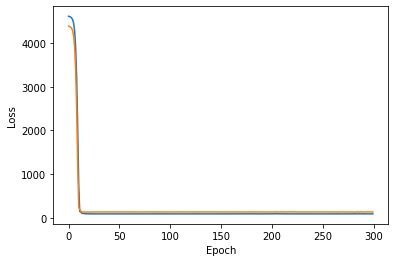

In [ ]:
plt.plot(range(num_epochs),r.history["loss"])
plt.plot(range(num_epochs),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model.predict(X_val)
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:", rms)

rmse: 11.548818922732314


Linear regression with topics

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept = False) # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr.fit(X, y)
predicted = regr.predict(X_val)

# df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
rms = mean_squared_error(y_val, predicted, squared= False)
print("rmse:", rms)
print("Coefficients: \n", regr.coef_)

rmse: 23.041579509148406
Coefficients: 
 [60.84615385 74.         69.80597015 68.52       66.63793103 66.5
 67.02040816]


In [ ]:
# for i in range(len(predicted)):
  # print("predicted mark:", predicted[i])
  # print("topic:", summaryDFVAL['sortedTopics'][i])
  # print("\n")

predDict = {}

for i in range(len(predicted)):

  if summaryDFVAL['topic'][i] in predDict:
    pass
  else:
    predDict[summaryDFVAL['topic'][i]] = predicted[i]




In [ ]:
predDict

{3: array([68.25]),
 2: array([69.5]),
 0: array([65.]),
 7: array([62.25]),
 4: array([73.5]),
 1: array([66.75]),
 5: array([65.75]),
 6: array([66.75])}

NN with topics and all features

In [ ]:
X = normalized_train_DF_topics[['numPages','numWords',"topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
y =  normalized_train_DF_topics['mark'].values

X_val = normalized_val_DF_topics[['numPages','numWords',"topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values
y_val =  normalized_val_DF_topics['mark'].values

In [ ]:
model = Sequential()
 
model.add(Dense(units=10, input_dim=10, kernel_initializer='he_normal', activation='linear'))
model.add(Dense(units=64, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=4, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1))

# model = Sequential()
 
# model.add(Dense(units=10, input_dim=10, kernel_initializer='he_normal', activation='linear'))
# model.add(Dense(units=64, kernel_initializer='he_normal', activation='relu',bias_regularizer = tf.keras.regularizers.L1(0.01) ))
# model.add(Dropout(0.25))
# model.add(Dense(units=4, kernel_initializer='he_normal', activation='relu'))
# model.add(Dense(1))

In [ ]:
# num_epochs =350
num_epochs =500

In [ ]:
loss_fn = keras.losses.MeanSquaredError()
num_epochs =num_epochs
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=loss_fn
)

In [ ]:
r = model.fit(X,y,epochs = num_epochs, verbose = 1,validation_data = [X_val,y_val])

Epoch 1/500
13/13 [==============================] - 1s 19ms/step - loss: 4683.1885 - val_loss: 4422.8813
Epoch 2/500
13/13 [==============================] - 0s 5ms/step - loss: 4616.0747 - val_loss: 4359.7930
Epoch 3/500
13/13 [==============================] - 0s 5ms/step - loss: 4562.5854 - val_loss: 4308.2168
Epoch 4/500
13/13 [==============================] - 0s 5ms/step - loss: 4511.6655 - val_loss: 4255.6816
Epoch 5/500
13/13 [==============================] - 0s 5ms/step - loss: 4459.5854 - val_loss: 4195.8960
Epoch 6/500
13/13 [==============================] - 0s 5ms/step - loss: 4397.8623 - val_loss: 4125.3853
Epoch 7/500
13/13 [==============================] - 0s 5ms/step - loss: 4316.1782 - val_loss: 4033.4839
Epoch 8/500
13/13 [==============================] - 0s 6ms/step - loss: 4215.3462 - val_loss: 3915.5977
Epoch 9/500
13/13 [==============================] - 0s 5ms/step - loss: 4084.0103 - val_loss: 3765.8208
Epoch 10/500
13/13 [==============================] - 

KeyboardInterrupt: ignored

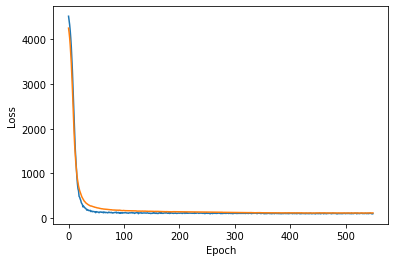

In [ ]:
plt.plot(range(num_epochs),r.history["loss"])
plt.plot(range(num_epochs),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model.predict(X_val)
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:", rms)

rmse: 10.69905044817466


NN with longformer embedding

In [ ]:
%cd

/root


In [ ]:
!unzip -qq /content/LongformerArray.zip

In [ ]:
import os
arrayList = []
nameList = []
for filename in os.listdir("/root/content/LongformerArray"):
  file = "/root/content/LongformerArray/" + filename

  arrayList.append(np.load(file))
  nameList.append(filename[:10])


In [ ]:
zipped = list(zip(nameList,arrayList))
LongArrDF = pd.DataFrame(zipped, columns=['reportID', "emb"])

In [ ]:
arrMarks = []

for index, row in LongArrDF.iterrows():
  ind = row["reportID"]
  ind = ind[:-2]

  t = getMark(marks,int(ind))
  arrMarks.append(t)




In [ ]:
LongArrDF["mark"] = arrMarks

In [ ]:
!unzip -qq /content/LongfromerArrayVal.zip

In [ ]:
arrayList = []
nameList = []
valFileNames = pd.read_csv('/content/docs/split_val.2022-08-08.txt',header = None)
valFileNames.columns = ["fileName"]
valFileNames = valFileNames.fileName.tolist()
for filename in os.listdir("/root/content/LongfromerArrayVal/"):
  file = "/root/content/LongfromerArrayVal/" + filename

  if int(filename[:8]) in valFileNames:
    arrayList.append(np.load(file))
    nameList.append(filename[:10])


zipped = list(zip(nameList,arrayList))
LongArrDF_val = pd.DataFrame(zipped, columns=['reportID', "emb"])


arrMarks = []

for index, row in LongArrDF_val.iterrows():
  ind = row["reportID"]
  ind = ind[:-2]

  t = getMark(marks,int(ind))
  arrMarks.append(t)


LongArrDF_val["mark"] = arrMarks

In [ ]:
c = LongArrDF_val[LongArrDF_val["reportID"]=='20210001_0'].emb.to_numpy()
c[0].shape

(1, 768)

In [ ]:
y = LongArrDF['mark'].values.reshape(-1, 1)
X = LongArrDF["emb"].to_numpy()

y_test = LongArrDF_val['mark'].values.reshape(-1, 1)
X_test = LongArrDF_val["emb"].to_numpy()
# y_test = summaryDFVAL['mark'].values.reshape(-1, 1)
# X_test = summaryDFVAL[["topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6","topic_7"]].values

In [ ]:
LongArrDF = LongArrDF.sort_values("reportID")
LongArrDF_val = LongArrDF_val.sort_values("reportID")
LongArrDF_val

,reportID,emb,mark
149,20210001_0,"[[0.15565898, -0.23084164, 0.09529348, 0.02056...",60.0
423,20210001_1,"[[0.18646263, -0.22786716, 0.118245885, -0.033...",60.0
452,20210001_1,"[[0.21389389, -0.24226241, 0.08033886, 0.00922...",60.0
632,20210001_1,"[[0.1646626, -0.24609424, 0.10720742, 0.009486...",60.0
322,20210001_2,"[[0.16931842, -0.2710591, 0.09840402, -0.01751...",60.0
...,...,...,...
313,20210059_5,"[[0.16078599, -0.27051505, 0.088312775, 0.0047...",53.0
599,20210059_6,"[[0.19179067, -0.2615901, 0.100126185, -0.0026...",53.0
498,20210059_7,"[[0.17198773, -0.22616164, 0.079411425, -0.011...",53.0
472,20210059_8,"[[0.17650245, -0.23346727, 0.088391736, 0.0100...",53.0


In [ ]:
# create CNN data
ids = []

for index, row in LongArrDF.iterrows():
  ind = row["reportID"]
  ids.append(ind[:8])

In [ ]:
LongArrDF["ID"] = ids
uniqueReportIds = LongArrDF["ID"].unique()

# (batch_size, height, width, depth)


In [ ]:
# create data for CNN 

CNN_train = np.zeros((len(uniqueReportIds),32,24,12))
for i in range(len(uniqueReportIds)):

  filtered_df = LongArrDF[LongArrDF["ID"]==uniqueReportIds[i]]

  f = filtered_df.sort_values("reportID")
  j = 0
  for index, row in f.iterrows():

    arr = row["emb"]
    
    arr = np.reshape(arr,(32,24))
    
    CNN_train[i,:,:,j] = arr
    j +=1
  

y_train = []

for i in uniqueReportIds:

  y_train.append(getMark(marks,int(i)))

ids = []

for index, row in LongArrDF_val.iterrows():
  ind = row["reportID"]
  ids.append(ind[:8])

LongArrDF_val["ID"] = ids
uniqueReportIds = LongArrDF_val["ID"].unique()

CNN_val = np.zeros((len(uniqueReportIds),32,24,12))
for i in range(len(uniqueReportIds)):

  filtered_df = LongArrDF_val[LongArrDF_val["ID"]==uniqueReportIds[i]]

  f = filtered_df.sort_values("reportID")
  j = 0
  for index, row in f.iterrows():

    arr = row["emb"]
    
    arr = np.reshape(arr,(32,24))
    
    CNN_val[i,:,:,j] = arr
    j +=1

y_val = []

for i in uniqueReportIds:

  y_val.append(getMark(marks,int(i)))


y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 24, 12)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='elu',bias_regularizer =tf.keras.regularizers.L1(0.01)))
model.add(layers.Dense(100, activation='sigmoid'))
model.add(layers.Dense(1))

In [ ]:
loss_fn = keras.losses.MeanSquaredError()
num_epochs =200
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0008),
    loss=loss_fn)

In [ ]:
r = model.fit(CNN_train,y_train,epochs = num_epochs, verbose = 1,validation_data = [CNN_val,y_val])

Epoch 1/200
13/13 [==============================] - 2s 49ms/step - loss: 4437.6353 - val_loss: 3982.0889
Epoch 2/200
13/13 [==============================] - 0s 36ms/step - loss: 4105.6157 - val_loss: 3812.3396
Epoch 3/200
13/13 [==============================] - 0s 34ms/step - loss: 3977.9395 - val_loss: 3710.6160
Epoch 4/200
13/13 [==============================] - 0s 36ms/step - loss: 3875.0889 - val_loss: 3637.7656
Epoch 5/200
13/13 [==============================] - 0s 35ms/step - loss: 3804.1353 - val_loss: 3548.7517
Epoch 6/200
13/13 [==============================] - 0s 36ms/step - loss: 3705.6506 - val_loss: 3475.2812
Epoch 7/200
13/13 [==============================] - 0s 35ms/step - loss: 3625.0034 - val_loss: 3394.1006
Epoch 8/200
13/13 [==============================] - 1s 41ms/step - loss: 3553.4504 - val_loss: 3330.1597
Epoch 9/200
13/13 [==============================] - 1s 44ms/step - loss: 3487.7761 - val_loss: 3267.7808
Epoch 10/200
13/13 [==========================

In [ ]:
np.sqrt(model.evaluate(CNN_val,y_val))

2/2 [==============================] - 0s 12ms/step - loss: 169.3170


13.01218606091937

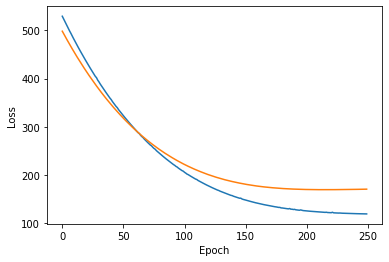

In [ ]:
plt.plot(range(num_epochs),r.history["loss"])
plt.plot(range(num_epochs),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model.predict(CNN_val)
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:", rms)

rmse: 13.05192014510574


SUPERVISOR AND EXAMINER ANALYSIS


In [ ]:
import pandas as pd
ExamDF = pd.read_csv("/content/sup_ex_ids.csv",delimiter = ";")
# ExamDF=ExamDF.dropna(axis = 0).reset_index(drop=True)
ExamDF = ExamDF[["supervisor_id", "examiner_id","report_id","mark"]]


In [ ]:
onehot = pd.get_dummies(ExamDF.examiner_id, prefix='ex', drop_first = False)
ExDF = pd.concat([ExamDF, onehot], axis=1)

# onehot = pd.get_dummies(ExamDF.supervisor_id, prefix='sup',drop_first= True)
# ExDF = pd.concat([ExamDF, onehot], axis=1)

ExamTrain = ExDF[:401]
ExamVal = ExDF[401:460]
ExamTest = ExDF[460:]

In [ ]:
y = ExamTrain['mark'].values.reshape(-1, 1)
X = ExamTrain.iloc[:, 4:ExamTrain.shape[1]].values
y_test = ExamVal['mark'].values.reshape(-1, 1)
X_test = ExamVal.iloc[:, 4:ExamTrain.shape[1]].values

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=False) # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr.fit(X, y)
predicted = regr.predict(X_test)

# df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
rms = mean_squared_error(y_test, predicted, squared=False)
print("rmse:", rms)
print("Coefficients: \n", regr.coef_)

rmse: 21.505863381721504
Coefficients: 
 [[5.80000000e+01 6.48461538e+01 6.76666667e+01 6.61666667e+01
  6.98000000e+01 6.32307692e+01 7.36666667e+01 7.10000000e+01
  7.00000000e+01 6.80769231e+01 6.70000000e+01 7.56000000e+01
  6.78000000e+01 6.90000000e+01 6.68333333e+01 7.21538462e+01
  7.25555556e+01 7.06923077e+01 6.80000000e+01 7.04545455e+01
  6.53750000e+01 7.56666667e+01 6.41250000e+01 6.45000000e+01
  5.14285714e+01 2.60635348e-16 6.63000000e+01 6.07857143e+01
  6.70833333e+01 6.61538462e+01 6.38000000e+01 6.58888889e+01
  6.26923077e+01 6.64000000e+01 6.65000000e+01 6.84000000e+01
  6.42000000e+01 7.59000000e+01 6.57000000e+01 6.81428571e+01
  6.80000000e+01 6.85000000e+01 7.26666667e+01 6.33333333e+01
  6.45000000e+01 7.63333333e+01 0.00000000e+00]]


In [ ]:
model = Sequential()
model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='he_normal', activation='relu'))

model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1))

In [ ]:
loss_fn = keras.losses.MeanSquaredError()
num_epochs =170
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=loss_fn
)

In [ ]:
r = model.fit(X,y,epochs = num_epochs, verbose = 0,validation_data = [X_test,y_test])

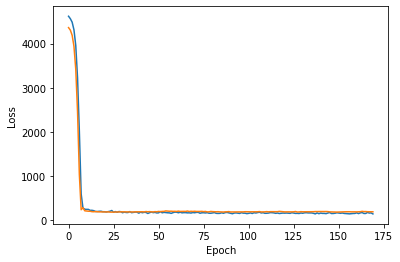

In [ ]:
plt.plot(range(num_epochs),r.history["loss"])
plt.plot(range(num_epochs),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rms)

rmse: 13.65566068861366


NN with features, topics and supervisors


In [ ]:
def getSup_id(df, reportID):

  index = df[df['report_id'] == int(reportID)].supervisor_id.tolist()
  index = index[0] 

  return index

def getEx_id(df, reportID):

  index = df[df['report_id'] == int(reportID)].examiner_id.tolist()
  index = index[0]

  return index

In [ ]:
ex_ids = []
sup_ids = []

for index, row in normalized_train_DF.iterrows():
    id = row["reportID"]
    ex = getEx_id(ExamDF,id)
    ex_ids.append(ex)

    sup = getSup_id(ExamDF, id)
    sup_ids.append(sup)


normalized_train_DF["supervisor"] = sup_ids
normalized_train_DF["examiner"] = ex_ids

ex_ids = []
sup_ids = []

for index, row in normalized_val_DF.iterrows():
    id = row["reportID"]
    ex = getEx_id(ExamDF,id)
    ex_ids.append(ex)

    sup = getSup_id(ExamDF, id)
    sup_ids.append(sup)


normalized_val_DF["supervisor"] = sup_ids
normalized_val_DF["examiner"] = ex_ids

ex_ids = []
sup_ids = []

for index, row in normalized_test_DF.iterrows():
    id = row["reportID"]
    ex = getEx_id(ExamDF,id)
    ex_ids.append(ex)

    sup = getSup_id(ExamDF, id)
    sup_ids.append(sup)


normalized_test_DF["supervisor"] = sup_ids
normalized_test_DF["examiner"] = ex_ids

In [ ]:
normalized_val_DF.columns.tolist()

['reportID',
 'numWords',
 'numPages',
 'n_spell_mistakes',
 'n_spell_mistakes_types',
 'n_figures',
 'n_tables',
 'n_equations',
 'n_references',
 'n_lines_start',
 'mark',
 'topic',
 'topic_0',
 'topic_1',
 'topic_2',
 'topic_3',
 'topic_4',
 'topic_5',
 'topic_6',
 'topic_7',
 'supervisor',
 'examiner']

In [ ]:
df_concat = pd.concat([normalized_train_DF,normalized_val_DF,normalized_test_DF])

In [ ]:
onehot = pd.get_dummies(df_concat.supervisor, prefix='sup')
df_concat= pd.concat([df_concat, onehot], axis=1)

onehot = pd.get_dummies(df_concat.examiner, prefix='ex')
df_concat= pd.concat([df_concat, onehot], axis=1)

normalized_val_DF = df_concat[401:460]
normalized_train_DF = df_concat[:401]
normalized_test_DF = df_concat[460:]


# onehot = pd.get_dummies(normalized_train_DF_topics.supervisor, prefix='sup')
# normalized_train_DF_topics = pd.concat([normalized_train_DF_topics, onehot], axis=1)

# onehot = pd.get_dummies(normalized_train_DF_topics.examiner, prefix='ex')
# normalized_train_DF_topics = pd.concat([normalized_train_DF_topics, onehot], axis=1)

# onehot = pd.get_dummies(normalized_val_DF_topics.supervisor, prefix='sup')
# normalized_val_DF_topics = pd.concat([normalized_val_DF_topics, onehot], axis=1)

# onehot = pd.get_dummies(normalized_val_DF_topics.examiner, prefix='ex')
# normalized_val_DF_topics = pd.concat([normalized_val_DF_topics, onehot], axis=1)

# onehot = pd.get_dummies(normalized_train_DF_topics.supervisor, prefix='sup')
# normalized_train_DF_topics = pd.concat([normalized_train_DF_topics, onehot], axis=1)

# onehot = pd.get_dummies(normalized_train_DF_topics.examiner, prefix='ex')
# normalized_train_DF_topics = pd.concat([normalized_train_DF_topics, onehot], axis=1)

# onehot = pd.get_dummies(normalized_val_DF_topics.supervisor, prefix='sup')
# normalized_val_DF_topics = pd.concat([normalized_val_DF_topics, onehot], axis=1)

# onehot = pd.get_dummies(normalized_val_DF_topics.examiner, prefix='ex')
# normalized_val_DF_topics = pd.concat([normalized_val_DF_topics, onehot], axis=1)



In [ ]:
normalized_val_DF.to_csv("/content/validation_all.csv")
normalized_train_DF.to_csv("/content/train_all.csv")
normalized_test_DF.to_csv("/content/test_all.csv")

In [ ]:
normalized_train_DF_topics.shape

(401, 113)

In [ ]:
fnames = []
for feature_name in normalized_train_DF_topics.columns:

  if feature_name not in normalized_val_DF_topics.columns.tolist():
    fnames.append(feature_name)

for i in fnames:

  normalized_val_DF_topics[i] = np.zeros(len(normalized_val_DF_topics),dtype = int)

fnames = []
for feature_name in normalized_val_DF_topics.columns:

  if feature_name not in normalized_train_DF_topics.columns.tolist():
    fnames.append(feature_name)

for i in fnames:

  normalized_train_DF_topics[i] = np.zeros(len(normalized_train_DF_topics),dtype = int)

In [ ]:
# if i != "mark" and i != "topic" and i != "supervisor" and i != 'examiner' and  i != 'reportID' 
fnames = []
for i in normalized_train_DF_topics.columns:
  # if i != "mark" and i != "topic" and i != "supervisor" and i != 'examiner' and  i != 'reportID':
  if  i != "topic" and i != 'examiner':
    fnames.append(i)
len(fnames)

113

In [ ]:
normalized_train_DF_topics[fnames].to_csv("wtf_train.csv")
normalized_val_DF_topics[fnames].to_csv("wtf_val.csv")

In [ ]:
normalized_val_DF_topics[fnames].to_csv("wtf_val1.csv")

In [ ]:
# y = normalized_train_DF_topics['mark'].values.reshape(-1, 1)
# X = normalized_train_DF_topics[fnames].to_numpy()
# y_test = normalized_val_DF_topics['mark'].values.reshape(-1, 1)
# X_test = normalized_val_DF_topics[fnames].to_numpy()

y = normalized_train_DF_topics['mark'].values.reshape(-1, 1)
X = normalized_train_DF_topics.iloc[:,12:normalized_train_DF_topics.shape[1]].to_numpy()
y_test = normalized_val_DF_topics['mark'].values.reshape(-1, 1)
X_test = normalized_val_DF_topics.iloc[:,12:normalized_val_DF_topics.shape[1]].to_numpy()

X = np.delete(X,8,axis = 1)
X = np.delete(X,8,axis = 1)

X_test = np.delete(X_test,8,axis = 1)
X_test = np.delete(X_test,8,axis = 1)

In [ ]:
X.shape

(401, 101)

AutoEncoder for categorical features

In [ ]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(101, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(X, X,
                epochs=150,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/150
13/13 [==============================] - 1s 14ms/step - loss: 0.2406 - val_loss: 0.2290
Epoch 2/150
13/13 [==============================] - 0s 5ms/step - loss: 0.2177 - val_loss: 0.2031
Epoch 3/150
13/13 [==============================] - 0s 4ms/step - loss: 0.1888 - val_loss: 0.1700
Epoch 4/150
13/13 [==============================] - 0s 4ms/step - loss: 0.1522 - val_loss: 0.1307
Epoch 5/150
13/13 [==============================] - 0s 5ms/step - loss: 0.1121 - val_loss: 0.0925
Epoch 6/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0772 - val_loss: 0.0637
Epoch 7/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0539 - val_loss: 0.0467
Epoch 8/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0414 - val_loss: 0.0383
Epoch 9/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0352 - val_loss: 0.0341
Epoch 10/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0322 - val_loss: 0.0319
Epoch 11

In [ ]:
encoded_imgs = autoencoder.encoder(X).numpy()
df = pd.DataFrame(encoded_imgs)

df_train = pd.concat([feature_train_df, df], axis=1)

encoded_imgs = autoencoder.encoder(X_test).numpy()
df = pd.DataFrame(encoded_imgs)

df_test = pd.concat([feature_val_df, df], axis=1)

In [ ]:
fnames = []

for i in df_train.columns:
  # if i != "mark" and i != "supervisor" and i != 'examiner' and  i != 'reportID' :
  if i != "mark" and i != "supervisor" and i != 'examiner' and  i != 'reportID' :
    fnames.append(i)

In [ ]:
y = df_train['mark'].values.reshape(-1, 1)
X = df_train[fnames].to_numpy()
y_test = df_test['mark'].values.reshape(-1, 1)
X_test = df_test[fnames].to_numpy()


In [ ]:
wtf_train = 

In [ ]:
model = Sequential()
model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='he_normal', activation='relu'))
model.add(Dense(units=18, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1))

loss_fn = keras.losses.MeanSquaredError()
num_epochs =180
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss=loss_fn
)

In [ ]:
r = model.fit(X,y,epochs = num_epochs, batch_size = 12, verbose = 1,validation_data = [X_test,y_test])

Epoch 1/180
34/34 [==============================] - 1s 7ms/step - loss: 4433.8330 - val_loss: 3887.2002
Epoch 2/180
34/34 [==============================] - 0s 3ms/step - loss: 3477.2019 - val_loss: 2499.7092
Epoch 3/180
34/34 [==============================] - 0s 3ms/step - loss: 1768.6232 - val_loss: 808.5005
Epoch 4/180
34/34 [==============================] - 0s 2ms/step - loss: 413.0204 - val_loss: 178.0355
Epoch 5/180
34/34 [==============================] - 0s 3ms/step - loss: 123.1298 - val_loss: 173.5233
Epoch 6/180
34/34 [==============================] - 0s 3ms/step - loss: 117.2997 - val_loss: 164.7273
Epoch 7/180
34/34 [==============================] - 0s 3ms/step - loss: 113.1191 - val_loss: 161.7781
Epoch 8/180
34/34 [==============================] - 0s 3ms/step - loss: 110.2374 - val_loss: 159.6783
Epoch 9/180
34/34 [==============================] - 0s 2ms/step - loss: 107.0329 - val_loss: 156.3386
Epoch 10/180
34/34 [==============================] - 0s 3ms/step - 

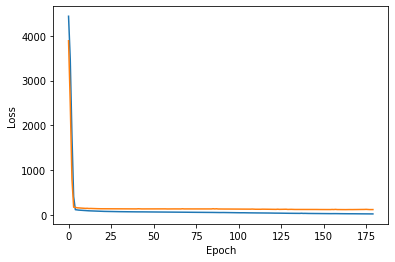

In [ ]:
plt.plot(range(num_epochs),r.history["loss"])
plt.plot(range(num_epochs),r.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rms)

rmse: 11.179337306064738


LR with Filesize

In [ ]:
fileSize = []
fileMark = []
trainNames = []
dirs = ["/content/2017/","/content/2018/","/content/2019/","/content/2020/"]

for ss in dirs:

  for filename in os.listdir(ss):
     
          dir = ss+ filename
          filename = dir
          file_stats = os.stat(filename)
          fileSize.append(file_stats.st_size / (1024 * 1024))
          m = getMark(marks,int(filename[14:-4]))
          fileMark.append(m)
          trainNames.append(int(filename[14:-4]))


valFileNames = pd.read_csv('/content/docs/split_val.2022-08-08.txt',header = None)
valFileNames.columns = ["fileName"]
valFileNames = valFileNames.fileName.tolist()
valMarks = []
valFileSize = []
valNames = []

for filename in os.listdir('/content/2021/'):
  if int(filename[:-4]) in valFileNames:
    dir = ""
    m = getMark(marks,int(filename[:-4]))
    valMarks.append(m)
    dir = '/content/2021/' + filename
    filename = dir
    file_stats = os.stat(filename)
    valFileSize.append(file_stats.st_size / (1024 * 1024))
    valNames.append(int(filename[14:-4]))


In [ ]:
import os

valFileNames = pd.read_csv('/content/docs/split_val.2022-08-08.txt',header = None)
valFileNames.columns = ["fileName"]
valFileNames = valFileNames.fileName.tolist()
valMarks = []
valFileSize = []
valNames = []

for filename in os.listdir('/content/2021/'):
  if int(filename[:-4]) not in valFileNames:
    dir = ""
    m = getMark(marks,int(filename[:-4]))
    valMarks.append(m)
    dir = '/content/2021/' + filename
    filename = dir
    file_stats = os.stat(filename)
    valFileSize.append(file_stats.st_size / (1024 * 1024))
    valNames.append(int(filename[14:-4]))

zipped = list(zip(valNames, valFileSize))
featDF = pd.DataFrame(zipped, columns=['Name', 'fileSize'])
featDF.to_csv("test_FILESIZE.csv")

In [ ]:
X = np.array(fileSize).reshape(-1,1)
X_val = np.array(valFileSize).reshape(-1,1)

y = fileMark
y_val = valMarks

In [ ]:
regressor1 = LinearRegression()
regressor1.fit(X, y)
y_pred = regressor1.predict(X_val)
rms = mean_squared_error(y_val, y_pred, squared=False)
print("rmse:", rms)

rmse: 13.018115954926202


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_val, y_pred)
print("mae:", mae)

mae: 9.882173079711093


In [ ]:
zipped = list(zip(trainNames, fileSize))
featDF = pd.DataFrame(zipped, columns=['Name', 'fileSize'])
featDF.to_csv("train_FILESIZE.csv")

zipped = list(zip(valNames, valFileSize))
featDF = pd.DataFrame(zipped, columns=['Name', 'fileSize'])
featDF.to_csv("val_FILESIZE.csv")